In [26]:
import warnings
warnings.filterwarnings('ignore')
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
!pip install earthengine-api geemap


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import ee
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [31]:
import geemap
ee.Initialize()

amazon = ee.FeatureCollection("RESOLVE/ECOREGIONS/2017").filter(ee.Filter.eq('ECO_NAME', 'Amazonia'))

srtm = ee.Image('USGS/SRTMGL1_003').clip(amazon)

Map = geemap.Map(center=[-3, -60], zoom=4)
Map.addLayer(amazon, {}, 'Amazon Biome')
Map.addLayer(srtm, {'min': 0, 'max': 3000, 'palette': ['blue', 'green', 'brown']}, 'Elevation')
Map

Map(center=[-3, -60], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chi…

In [6]:
!pip install rasterio


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
# Define large bounding box manually
region = ee.Geometry.BBox(-70, -10, -55, 2)  # A section of the Amazon

# Load SRTM elevation data
srtm = ee.Image("USGS/SRTMGL1_003").clip(region)

# Set number of tiles in each direction
num_tiles_x = 5
num_tiles_y = 5

# Get the bounding box coordinates
coords = region.bounds().coordinates().get(0)
coords = ee.List(coords)

minLon = ee.Number(ee.List(coords.get(0)).get(0))
minLat = ee.Number(ee.List(coords.get(0)).get(1))
maxLon = ee.Number(ee.List(coords.get(2)).get(0))
maxLat = ee.Number(ee.List(coords.get(2)).get(1))

# Calculate step size
stepLon = maxLon.subtract(minLon).divide(num_tiles_x)
stepLat = maxLat.subtract(minLat).divide(num_tiles_y)

# Export each tile
for i in range(num_tiles_x):
    for j in range(num_tiles_y):
        tile_minLon = minLon.add(stepLon.multiply(i))
        tile_minLat = minLat.add(stepLat.multiply(j))
        tile_maxLon = tile_minLon.add(stepLon)
        tile_maxLat = tile_minLat.add(stepLat)

        tile = ee.Geometry.BBox(tile_minLon, tile_minLat, tile_maxLon, tile_maxLat)

        description = f"SRTM_Tile_{i}_{j}"

        task = ee.batch.Export.image.toDrive(
            image=srtm,
            region=tile,
            scale=90,
            maxPixels=1e8,
            description=description,
            fileFormat='GeoTIFF'
        )
        task.start()
        print(f"Started export: {description}")

EEException: Request had insufficient authentication scopes.

In [ ]:
print(task.status())


{'state': 'COMPLETED', 'description': 'SRTM_Tile_4_4', 'priority': 100, 'creation_timestamp_ms': 1748740193631, 'update_timestamp_ms': 1748740808055, 'start_timestamp_ms': 1748740610169, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/'], 'attempt': 1, 'batch_eecu_usage_seconds': 8.96552848815918, 'id': 'LA7CKLK7KRQRFXQG3LP4EZ4V', 'name': 'projects/696774122295/operations/LA7CKLK7KRQRFXQG3LP4EZ4V'}


#### Feature Engineering

In [27]:
def compute_slope(elevation, pixel_size):
    dx, dy = np.gradient(elevation, pixel_size, pixel_size)
    slope_rad = np.sqrt(dx**2 + dy**2)
    return np.degrees(np.arctan(slope_rad))

def compute_hillshade(elevation, azimuth=315, altitude=45, pixel_size=30):
    from matplotlib.colors import LightSource
    ls = LightSource(azdeg=azimuth, altdeg=altitude)
    return ls.hillshade(elevation, vert_exag=1, dx=pixel_size, dy=pixel_size)

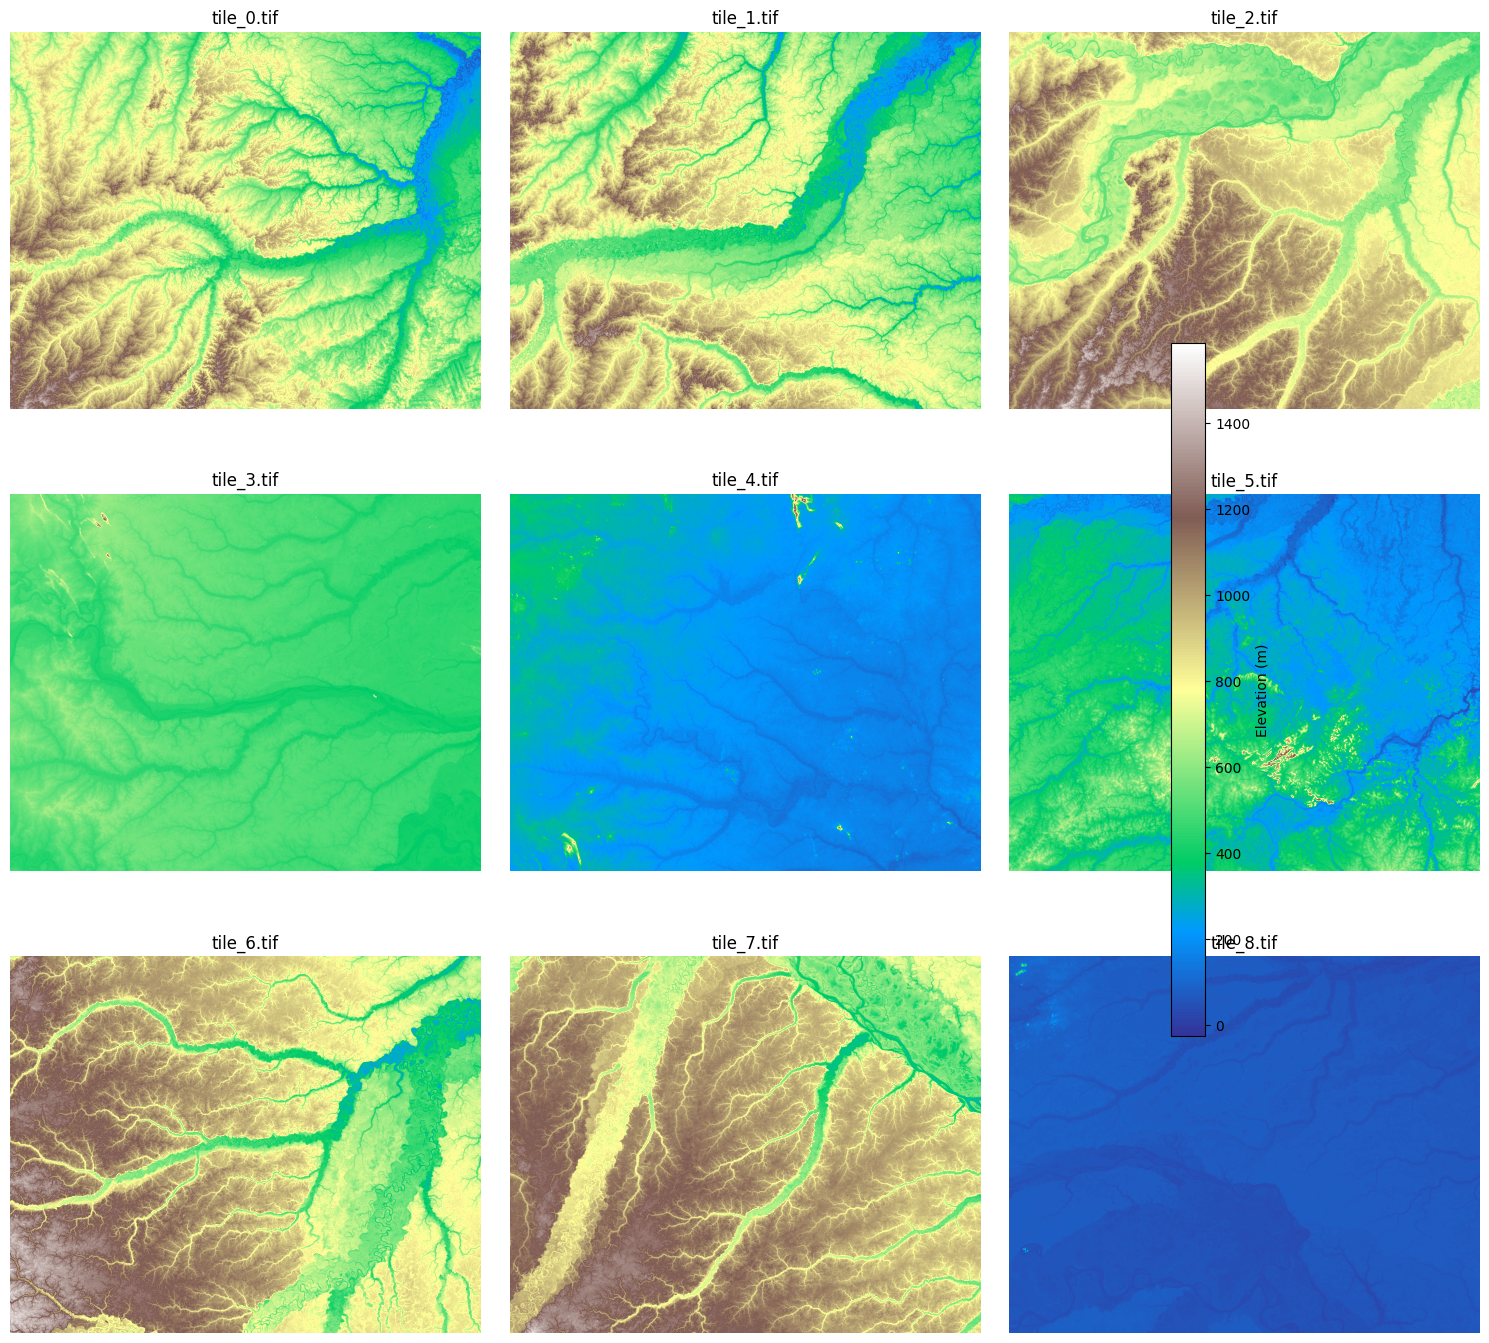

Tile-wise EDA summary:

tile_0.tif: min=75.0, max=315.0, mean=184.32, std=32.67, slope_mean=2.98, slope_std=1.90, hillshade_mean=0.58, hillshade_std=0.07
tile_1.tif: min=61.0, max=247.0, mean=144.72, std=24.60, slope_mean=2.40, slope_std=1.66, hillshade_mean=0.55, hillshade_std=0.06
tile_2.tif: min=-24.0, max=208.0, mean=104.44, std=28.44, slope_mean=2.06, slope_std=1.51, hillshade_mean=0.61, hillshade_std=0.03
tile_3.tif: min=-166.0, max=684.0, mean=107.20, std=26.90, slope_mean=2.10, slope_std=1.57, hillshade_mean=0.79, hillshade_std=0.02
tile_4.tif: min=-19.0, max=972.0, mean=132.40, std=38.42, slope_mean=2.28, slope_std=2.17, hillshade_mean=0.75, hillshade_std=0.02
tile_5.tif: min=40.0, max=434.0, mean=125.98, std=30.29, slope_mean=1.97, slope_std=1.82, hillshade_mean=0.66, hillshade_std=0.03
tile_6.tif: min=15.0, max=155.0, mean=93.56, std=21.85, slope_mean=1.88, slope_std=1.40, hillshade_mean=0.64, hillshade_std=0.04
tile_7.tif: min=-10.0, max=136.0, mean=77.84, std=18.04, slope_

In [28]:
folder = "asset"
file_names = sorted([f for f in os.listdir(folder) if f.endswith(".tif")])

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# store EDA results
eda_results = []

for i, ax in enumerate(axes.flat):
    file_path = os.path.join(folder, file_names[i])
    with rasterio.open(file_path) as src:
        elevation = src.read(1)
        # mask out nodata values if the exist
        if src.nodata is not None:
            elevation = np.ma.masked_equal(elevation, src.nodata)
        
        # visualization
        im = ax.imshow(elevation, cmap='terrain')
        ax.set_title(f"{file_names[i]}")
        ax.axis("off")
        slope = compute_slope(elevation, pixel_size=90)
        hillshade = compute_hillshade(elevation, pixel_size=90)
        # compute EDA
        eda = {
            "file": file_names[i],
            "min": float(np.min(elevation)),
            "max": float(np.max(elevation)),
            "mean": float(np.mean(elevation)),
            "std": float(np.std(elevation)),
            "slope_mean": float(np.mean(slope)),
            "slope_std": float(np.std(slope)),
            "hillshade_mean": float(np.mean(hillshade)),
            "hillshade_std": float(np.std(hillshade))
        }
        eda_results.append(eda)

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, label="Elevation (m)")
plt.tight_layout()
plt.show()

# print EDA summary
print("Tile-wise EDA summary:\n")
for eda in eda_results:
    print(f"{eda['file']}: min={eda['min']}, max={eda['max']}, mean={eda['mean']:.2f}, std={eda['std']:.2f}, slope_mean={eda['slope_mean']:.2f}, slope_std={eda['slope_std']:.2f}, hillshade_mean={eda['hillshade_mean']:.2f}, hillshade_std={eda['hillshade_std']:.2f}")

In [15]:
!pip install scikit-image

   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
    --------------------------------------- 0.3/12.9 MB ? eta -:--:--
   -- ------------------------------------- 0.8/12.9 MB 2.0 MB/s eta 0:00:07
   --- ------------------------------------ 1.0/12.9 MB 1.9 MB/s eta 0:00:07
   ---- ----------------------------------- 1.3/12.9 MB 2.0 MB/s eta 0:00:06
   ----- ---------------------------------- 1.8/12.9 MB 1.9 MB/s eta 0:00:06
   ------- -------------------------------- 2.4/12.9 MB 1.9 MB/s eta 0:00:06
   -------- ------------------------------- 2.6/12.9 MB 1.9 MB/s eta 0:00:06
   --------- ------------------------------ 3.1/12.9 MB 1.9 MB/s eta 0:00:06
   ---------- ----------------------------- 3.4/12.9 MB 1.9 MB/s eta 0:00:06
   ------------ --------------------------- 3.9/12.9 MB 1.9 MB/s eta 0:00:05
   ------------- -------------------------- 4.2/12.9 MB 1.9 MB/s eta 0:00:05
   -------------- ------------------------- 4.7/12.9 MB 1.9 MB/s eta 0:00:05
   ----------


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
# The new shape (100, 100) to resize the elevation tile to — useful for standardizing size across tiles.
from skimage.transform import resize

elevation = resize(elevation, (100, 100), mode='edge', preserve_range=True)

In [30]:
# Normalize to 0–1 for ML use
elevation_norm = (elevation - elevation.min()) / (elevation.max() - elevation.min())


In [49]:
print(4%3)

1
